# 0. Setup

In [2]:
## Testing optimized code
# Verify we're in the correct working directory
import os, sys
import git 
from pathlib import Path

def get_project_root():
    return Path(git.Repo('.', search_parent_directories=True).working_tree_dir)

root = get_project_root()

os.chdir(root)
os.getcwd()

print(sys.path)

['/Users/aidan.mcloughlin/Library/CloudStorage/OneDrive-Veracyte,Inc/Desktop/work/dmPC_opt/scripts_model', '/Users/aidan.mcloughlin/miniconda3/envs/drug_resp/lib/python3.9/site-packages/git/ext/gitdb', '/Users/aidan.mcloughlin/miniconda3/envs/drug_resp/lib/python39.zip', '/Users/aidan.mcloughlin/miniconda3/envs/drug_resp/lib/python3.9', '/Users/aidan.mcloughlin/miniconda3/envs/drug_resp/lib/python3.9/lib-dynload', '', '/Users/aidan.mcloughlin/miniconda3/envs/drug_resp/lib/python3.9/site-packages']


In [3]:
plot_folder = "results/images/simulations/"

## import packages, models, trainers

In [5]:
import argparse
import logging
import sys
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

import torch
from torch import nn, optim, Tensor
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

print('pytorch version:', torch.__version__)
print('orig num threads:', torch.get_num_threads())

pytorch version: 2.0.1
orig num threads: 8


In [6]:
from models import *
from trainers import *
from losses import *
from utils import *
from visuals import *

In [7]:
import random
seed=42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. Prepare dataset

## Load 

In [8]:
simu_folder = "data/simulations"
RNAseq = pd.read_csv(os.path.join(simu_folder, "simu2_RNAseq.csv"), index_col = 0)
RNAseq_meta = pd.read_csv(os.path.join(simu_folder, "simu2_RNAseq_meta.csv"), index_col = 0)
d_fp = pd.read_csv(os.path.join(simu_folder, "simu2_d_fp.csv"), index_col = 0)
# cdr = pd.read_csv(os.path.join(simu_folder, "simu2_cdr.csv"), index_col = 0)
cdr = pd.read_csv(os.path.join(simu_folder, "simu2.2_cdr_noise.csv"), index_col = 0)

In [9]:
RNAseq_meta['C_type'] = RNAseq_meta['C_type'].replace('grp3', 'grp0')

In [10]:
c_data = RNAseq.T

# originally
c_meta, meta_map = get_CCL_meta_codes(RNAseq.columns.values, RNAseq_meta)

print(f"Cancer type coding map: ")
print(meta_map)

d_data = d_fp.T

cdr = cdr
cdr.index = cdr.index.astype("str")

Cancer type coding map: 
  C_type  code  count
0   grp0     0     62
4   grp1     1     35
8   grp2     2     41


In [11]:
num_cluster = 3

# only two groups
two_grp = True
if two_grp:
    num_cluster = 2
    RNAseq_meta.loc[RNAseq_meta.C_type=='grp2', 'C_type'] = 'grp1'
    
    c_meta_true = c_meta
    c_meta, meta_map = get_CCL_meta_codes(RNAseq.columns.values, RNAseq_meta)
    print(f"Cancer type coding map: ")
    print(meta_map)

Cancer type coding map: 
  C_type  code  count
0   grp0     0     62
3   grp1     1     76


## Train & Test split

In [13]:
c_train, c_test = train_test_split(c_data, test_size=0.15)

c_meta_train = get_CCL_meta(c_train.index.values, c_meta)
c_meta_test = get_CCL_meta(c_test.index.values, c_meta)

cdr_train_idx = np.isin(cdr.index.values, c_train.index.values)
cdr_train = cdr[cdr_train_idx]
cdr_test = cdr[~cdr_train_idx]

if two_grp:
    c_meta_train_true = get_CCL_meta(c_train.index.values, c_meta_true)
    c_meta_test_true = get_CCL_meta(c_test.index.values, c_meta_true)

In [14]:
print(f"Training data: \n   cdr: {cdr_train.shape}\n   c_data: {c_train.shape} \n   d_data: {d_data.shape}")
print(f"   Number of each initial cancer clusters: \n")
if two_grp:
    print(pd.crosstab(c_meta_train_true['code'], c_meta_train['code'], margins=True, margins_name="Total"))
else:
    print(c_meta_train['code'].value_counts())

print(f"\nTesting data:  \n   cdr: {cdr_test.shape}\n   c_data: {c_test.shape} \n   d_data: {d_data.shape}")
print(f"   Number of each initial cancer clusters: \n")
if two_grp:
    print(pd.crosstab(c_meta_test_true['code'], c_meta_test['code'], margins=True, margins_name="Total"))
else:
    print(c_meta_test['code'].value_counts())


Training data: 
   cdr: (117, 30)
   c_data: (117, 355) 
   d_data: (30, 150)
   Number of each initial cancer clusters: 

code    0   1  Total
code                
0      53   0     53
1       0  29     29
2       0  35     35
Total  53  64    117

Testing data:  
   cdr: (21, 30)
   c_data: (21, 355) 
   d_data: (30, 150)
   Number of each initial cancer clusters: 

code   0   1  Total
code               
0      9   0      9
1      0   6      6
2      0   6      6
Total  9  12     21


# 2. Hyperparameters

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# torch.cuda.set_device(device)
print(device)

cpu


In [16]:
c_data.shape

(138, 355)

In [17]:
class Train_Args:
    def __getitem__(self, key):
        return getattr(self, key)
    def __setitem__(self, key, val):
        setattr(self, key, val)
    def __contains__(self, key):
        return hasattr(self, key)

    valid_size = 0.2 #@param {type: "float"}

    n_epochs = 100 #@param {type: "integer"}
    batch_size = None #@param {type: "integer"}
    lr = 0.01 #@param {type: "float"}
    
    C_VAE_loss_weight = 0.1 #@param {type: "float"}
    C_recon_loss_weight = 1 #@param {type: "float"}
    C_kld_weight = 0.5 #@param {type: "float"}
    C_cluster_distance_weight = 5 #@param {type: "float"}  
    C_update_ratio_weight = 5 #@param {type: "float"}
    
    D_VAE_loss_weight = 0.5 #@param {type: "float"}
    D_recon_loss_weight = 1 #@param {type: "float"}
    D_kld_weight = 0.25 #@param {type: "float"}
    D_cluster_distance_weight = 5 #@param {type: "float"}
    D_update_ratio_weight = 5 #@param {type: "float"}
    
    predict_loss_weight = 2500 #@param {type: "float"}

    rm_cluster_outliers = False #@param {type: "bool"}
    
    cVAE_save_path = 'data/model_fits/GDSC_simu2.2_c_vae' #@param
    dVAE_save_path = 'data/model_fits/GDSC_simu2.2_d_vae' #@param
    
    c_p_save_path = 'data/model_fits/GDSC_simu2.2_c_vae_predictor' #@param
    d_p_save_path = 'data/model_fits/GDSC_simu2.2_d_vae_predictor' #@param
    

class CDPModel_sub_Args:
    def __getitem__(self, key):
        return getattr(self, key)
    def __setitem__(self, key, val):
        setattr(self, key, val)
    def __contains__(self, key):
        return hasattr(self, key)

    # c_VAE
    c_input_dim = 0 #@param {type: "integer"}
    c_h_dims = [64] #@param {type: "vactor"}
    c_latent_dim = 32 #@param {type: "integer"}

    # d_VAE
    d_input_dim = 0 #@param {type: "integer"}
    d_h_dims = [64]  #@param {type: "vactor"}
    d_latent_dim = 32 #@param {type: "integer"}

    # predictor
    p_sec_dim = 32 #@param {type: "integer"}
    p_h_dims = [p_sec_dim*2, 16]  #@param {type: "vactor"}
    
    # all
    drop_out = 0  #@param {type: "float"}
    
    # sensitive threshold
    sens_cutoff = 0.5


In [18]:
train_args = Train_Args()

K = len(c_meta['code'].unique())

CDPmodel_sim2_2_args = CDPModel_sub_Args()
CDPmodel_sim2_2_args['c_input_dim'] = c_data.shape[1] 
CDPmodel_sim2_2_args['d_input_dim'] = d_data.shape[1]


if CDPmodel_sim2_2_args['c_input_dim'] <= 0:
  warnings.warn(
      '''\nCancer Cell line feat222iiZZXCx9MWWMW                           ure number not specified''')
if CDPmodel_sim2_2_args['d_input_dim'] <= 0:
  warnings.warn(
      '''\nDrug feature number not specified''')

# 3. Train Model

In [21]:
CDPmodel_sim2_2 = CDPmodel(K, CDPmodel_sim2_2_args)
n_rounds = 5
fit_returns = CDPmodel_sim2_2.fit(c_train, c_meta_train, d_data, cdr_train, train_args, n_rounds=n_rounds, search_subcluster=True, device = device)
c_meta, c_meta_hist, d_sens_hist, losses_train_hist_list, best_epos_list, C_VAE_init_losses, D_VAE_init_losses, c_latent_list, d_latent_list = fit_returns

AttributeError: 'int' object has no attribute 'values'

# 4. Results and visualizations

## 4.1. Prediction:

### Training data:

In [20]:
cdr_train_hat = CDPmodel_sim2_2.predict(c_train, d_data)

cdr_train_rslt = cdr_train.copy()
cdr_train_rslt['c_name'] = cdr_train_rslt.index.values
cdr_train_rslt = pd.melt(cdr_train_rslt, id_vars='c_name', value_vars=None, var_name=None, value_name='value', col_level=None)
cdr_train_rslt = cdr_train_rslt.rename(columns={'variable':'d_name', 'value':'cdr'})

cdr_train_rslt = pd.merge(cdr_train_rslt, cdr_train_hat, on=['c_name', 'd_name'], how='outer')

In [79]:
cdr_train_rslt.head()

,c_name,d_name,cdr,cdr_hat,cdr_all,cluster,c_cluster,d_cluster
0,c1_1,d1_1,1.0,0.999986,0.999986,2,1 & 2,2
1,c1_2,d1_1,1.0,0.999975,0.999975,2,1 & 2,2
2,c1_3,d1_1,1.0,0.9999,0.9999,2,1 & 2,2
3,c1_4,d1_1,1.0,0.999971,0.999971,2,1 & 2,2
4,c1_5,d1_1,1.0,0.999993,0.999993,2,1 & 2,2


In [80]:
cdr_train_hat.cluster.value_counts()

-1    2027
1      693
0      520
2      270
Name: cluster, dtype: int64

In [81]:
# Binary cross entropy
cdr_train_rslt_noNA = cdr_train_rslt.dropna(subset=['cdr_hat', 'cdr'])
binary_cross_entropy_train = log_loss(cdr_train_rslt_noNA['cdr'], cdr_train_rslt_noNA['cdr_hat'])
print(f"Binary cross entropy: {round(binary_cross_entropy_train, 4)}")


# Area Under the Curve (AUC) for a Receiver Operating Characteristic (ROC) 
roc_auc = roc_auc_score(cdr_train_rslt_noNA['cdr'], cdr_train_rslt_noNA['cdr_hat'])
print("ROC AUC:", round(roc_auc,4))

# confusion_ atrix
cdr_train_rslt_noNA['cdr_hat_bnr'] = (cdr_train_rslt_noNA['cdr_hat'] > 0.5).astype(int)

conf_matrix = confusion_matrix(cdr_train_rslt_noNA['cdr'], cdr_train_rslt_noNA['cdr_hat_bnr'])
tn, fp, fn, tp = conf_matrix.ravel()

print(f"\nTrue Positive:  {tp} ({(tp / (tp + fn)) * 100:.2f} %)")
print(f"False Negative: {fn} ({(fn / (fn + tp)) * 100:.2f} %)")

print(f"True Negative:  {tn} ({(tn / (tn + fp)) * 100:.2f} %)")
print(f"False Positive: {fp} ({(fp / (fp + tn)) * 100:.2f} %)")

Binary cross entropy: 1.1649
ROC AUC: 0.9596

True Positive:  1318 (92.56 %)
False Negative: 106 (7.44 %)
True Negative:  1875 (97.45 %)
False Positive: 49 (2.55 %)


/var/folders/tb/56hsz7_j6pj5735qyd47cz440000gp/T/ipykernel_24877/3513222124.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdr_train_rslt_noNA['cdr_hat_bnr'] = (cdr_train_rslt_noNA['cdr_hat'] > 0.5).astype(int)


In [82]:
cdr_train_hat.to_csv(os.path.join(simu_folder, "GDSC_simu2.2_cdr_hat_train.csv"), index=True)

### Testing data

In [83]:
cdr_test_hat = CDPmodel_sim2_2.predict(c_test, d_data, sd_scale = 6)

cdr_test_rslt = cdr_test.copy()
cdr_test_rslt['c_name'] = cdr_test_rslt.index.values
cdr_test_rslt = pd.melt(cdr_test_rslt, id_vars='c_name', value_vars=None, var_name=None, value_name='value', col_level=None)
cdr_test_rslt = cdr_test_rslt.rename(columns={'variable':'d_name', 'value':'cdr'})

cdr_test_rslt = pd.merge(cdr_test_rslt, cdr_test_hat, on=['c_name', 'd_name'], how='outer')

In [84]:
# Binary cross entropy
cdr_test_rslt_noNA = cdr_test_rslt.dropna(subset=['cdr_hat', 'cdr'])
binary_cross_entropy_test = log_loss(cdr_test_rslt_noNA['cdr'], cdr_test_rslt_noNA['cdr_hat'])
print(f"Binary cross entropy: {round(binary_cross_entropy_test, 4)}")


# Area Under the Curve (AUC) for a Receiver Operating Characteristic (ROC) 
roc_auc = roc_auc_score(cdr_test_rslt_noNA['cdr'], cdr_test_rslt_noNA['cdr_hat'])
print("ROC AUC:", round(roc_auc,4))

# confusion_ atrix
cdr_test_rslt_noNA['cdr_hat_bnr'] = (cdr_test_rslt_noNA['cdr_hat'] > 0.5).astype(int)

conf_matrix = confusion_matrix(cdr_test_rslt_noNA['cdr'], cdr_test_rslt_noNA['cdr_hat_bnr'])
tn, fp, fn, tp = conf_matrix.ravel()

print(f"\nTrue Positive:  {tp} ({(tp / (tp + fn)) * 100:.2f} %)")
print(f"False Negative: {fn} ({(fn / (fn + tp)) * 100:.2f} %)")

print(f"True Negative:  {tn} ({(tn / (tn + fp)) * 100:.2f} %)")
print(f"False Positive: {fp} ({(fp / (fp + tn)) * 100:.2f} %)")


Binary cross entropy: 1.5538
ROC AUC: 0.8931

True Positive:  230 (85.50 %)
False Negative: 39 (14.50 %)
True Negative:  279 (83.78 %)
False Positive: 54 (16.22 %)


/var/folders/tb/56hsz7_j6pj5735qyd47cz440000gp/T/ipykernel_24877/4166520338.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdr_test_rslt_noNA['cdr_hat_bnr'] = (cdr_test_rslt_noNA['cdr_hat'] > 0.5).astype(int)


## 4.2. Clustering
### Trainning data

In [85]:
c_meta_train_tmp = c_meta_train.loc[:, ['code']]
c_meta_train_tmp['c_name'] = c_meta_train_tmp.index.values.astype(str)
c_meta_train_tmp = c_meta_train_tmp.rename(columns={'code':'cluster_init'})

cdr_train_rslt_tmp = cdr_train_rslt[['c_name', 'cluster']]
cdr_train_rslt_tmp = cdr_train_rslt_tmp.drop_duplicates()
cdr_train_rslt_tmp['c_name'] = cdr_train_rslt_tmp['c_name'].astype(str)

cdr_train_rslt_cluster = pd.merge(cdr_train_rslt_tmp, c_meta_train_tmp, on='c_name', how='left')

print("CD-bicluster:")
if two_grp:
    c_meta_true_tmp = c_meta_true.loc[:, ['code']]
    c_meta_true_tmp['c_name'] = c_meta_true_tmp.index.values.astype(str)
    c_meta_true_tmp = c_meta_true_tmp.rename(columns={'code':'cluster_true'})

    cdr_train_rslt_cluster = pd.merge(cdr_train_rslt_cluster, c_meta_true_tmp, on='c_name', how='left')
    
    print(pd.crosstab([cdr_train_rslt_cluster['cluster_true'], cdr_train_rslt_cluster['cluster_init']], cdr_train_rslt_cluster['cluster']))
else:
    print(pd.crosstab(cdr_train_rslt_cluster['cluster_init'], cdr_train_rslt_cluster['cluster']))

    


CD-bicluster:
cluster                    -1   0   1   2
cluster_true cluster_init                
0            0             54  52   0   0
1            1             30   0  30  30
2            1             33   0  33   0


In [86]:
cdr_train_rslt_tmp = cdr_train_rslt[['c_name', 'c_cluster']]
cdr_train_rslt_tmp = cdr_train_rslt_tmp.drop_duplicates()
cdr_train_rslt_tmp['c_name'] = cdr_train_rslt_tmp['c_name'].astype(str)

cdr_train_rslt_cluster = pd.merge(cdr_train_rslt_tmp, c_meta_train_tmp, on='c_name', how='left')

print("Cancer cluster:")
if two_grp:
    c_meta_true_tmp = c_meta_true.loc[:, ['code']]
    c_meta_true_tmp['c_name'] = c_meta_true_tmp.index.values.astype(str)
    c_meta_true_tmp = c_meta_true_tmp.rename(columns={'code':'cluster_true'})

    cdr_train_rslt_cluster = pd.merge(cdr_train_rslt_cluster, c_meta_true_tmp, on='c_name', how='left')
    
    print(pd.crosstab([cdr_train_rslt_cluster['cluster_true'], cdr_train_rslt_cluster['cluster_init']], cdr_train_rslt_cluster['c_cluster']))
else:
    print(pd.crosstab(cdr_train_rslt_cluster['cluster_init'], cdr_train_rslt_cluster['c_cluster']))


Cancer cluster:
c_cluster                  -1   0   1  1 & 2
cluster_true cluster_init                   
0            0              2  52   0      0
1            1              0   0   0     30
2            1              0   0  33      0


In [87]:
print('Sensitive to clusters before:')
print(d_sens_hist.sensitive_k.value_counts())
print('Sensitive to clusters after:')
print(d_sens_hist.sensitive_k_latest.value_counts())


Sensitive to clusters before:
-1    10
1     10
0     10
Name: sensitive_k, dtype: int64
Sensitive to clusters after:
1     11
0     10
-1     9
Name: sensitive_k_latest, dtype: int64


### Testing data

In [88]:
c_meta_test_tmp = c_meta_test.loc[:, ['code']]
c_meta_test_tmp['c_name'] = c_meta_test_tmp.index.values.astype(str)
c_meta_test_tmp = c_meta_test_tmp.rename(columns={'code':'cluster_init'})

cdr_test_rslt_tmp = cdr_test_rslt[['c_name', 'cluster']]
cdr_test_rslt_tmp = cdr_test_rslt_tmp.drop_duplicates()
cdr_test_rslt_tmp['c_name'] = cdr_test_rslt_tmp['c_name'].astype(str)


cdr_test_rslt_cluster = pd.merge(cdr_test_rslt_tmp, c_meta_test_tmp, on='c_name', how='left')

print("CD-bicluster:")

if two_grp:
    cdr_test_rslt_cluster = pd.merge(cdr_test_rslt_cluster, c_meta_true_tmp, on='c_name', how='left')
    
    print(pd.crosstab([cdr_test_rslt_cluster['cluster_true'], cdr_test_rslt_cluster['cluster_init']], cdr_test_rslt_cluster['cluster']))
else:
    print(pd.crosstab(cdr_test_rslt_cluster['cluster_init'], cdr_test_rslt_cluster['cluster']))
    

CD-bicluster:
cluster                    -1  0  1  1 & 2  2
cluster_true cluster_init                    
0            0              8  8  2      0  8
1            1              5  1  3      4  3
2            1              8  1  8      4  8


In [89]:
cdr_test_rslt_tmp = cdr_test_rslt[['c_name', 'c_cluster']]
cdr_test_rslt_tmp = cdr_test_rslt_tmp.drop_duplicates()
cdr_test_rslt_tmp['c_name'] = cdr_test_rslt_tmp['c_name'].astype(str)

cdr_test_rslt_cluster = pd.merge(cdr_test_rslt_tmp, c_meta_test_tmp, on='c_name', how='left')

print("Cancer cluster:")
if two_grp:
    c_meta_true_tmp = c_meta_true.loc[:, ['code']]
    c_meta_true_tmp['c_name'] = c_meta_true_tmp.index.values.astype(str)
    c_meta_true_tmp = c_meta_true_tmp.rename(columns={'code':'cluster_true'})

    cdr_test_rslt_cluster = pd.merge(cdr_test_rslt_cluster, c_meta_true_tmp, on='c_name', how='left')
    
    print(pd.crosstab(cdr_test_rslt_cluster['cluster_true'], cdr_test_rslt_cluster['c_cluster']))



Cancer cluster:
c_cluster     0 & 2  1 & 2
cluster_true              
0                 8      0
1                 1      4
2                 0      8


## Visualizations

In [90]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns

### Trainning data:

FileNotFoundError: [Errno 2] No such file or directory: 'results/images/simulations/simu2.2_2clusters_c_latent_k0.png'

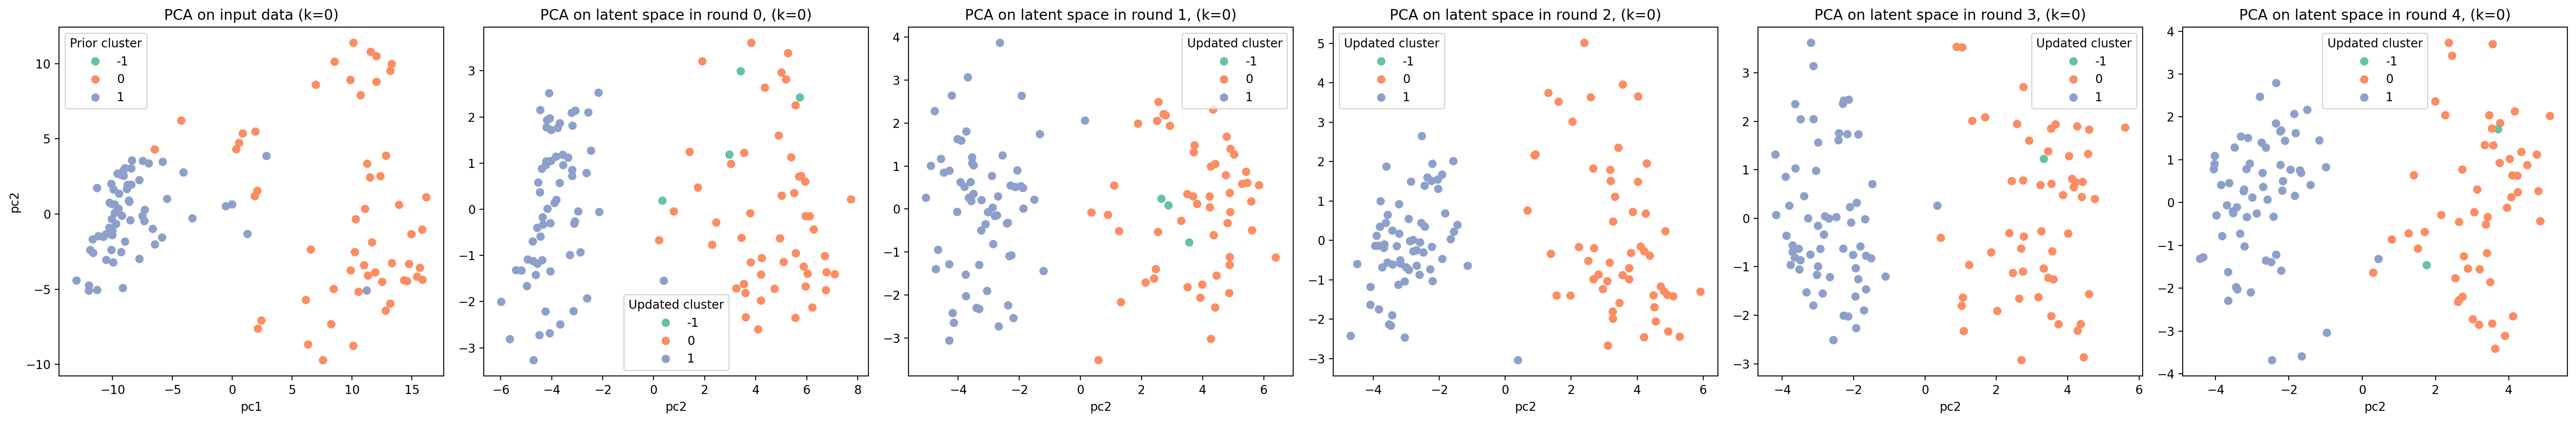

In [91]:
plot_c_PCA_latent(c_train, n_rounds, fit_returns, model=CDPmodel, plots_save_path=f'{plot_folder}simu2.2_{num_cluster}clusters_c_latent')

In [ ]:
plot_d_PCA_latent(d_data, n_rounds, fit_returns, model=CDPmodel_sim2_2, plots_save_path=f'{plot_folder}simu2.2_{num_cluster}clusters_d_latent')

### Adding testing data:

In [ ]:
for k in range(-1, CDPmodel_sim2_2.K):
    plot_c_PCA_latent_test(CDPmodel_sim2_2, device, n_rounds, c_latent_list, c_train, c_test, cdr_train_rslt_cluster, cdr_test_rslt_cluster, k=k, 
                       plot_save_path=f'{plot_folder}simu2.2_{num_cluster}clusters_c_latent_k{k}_test_data.png')

### Losses:

In [ ]:
for k in range(CDPmodel_sim2_2.K):
    print(f'k = {k}:')
    for b in range(n_rounds):
        print(f'round {b}:')
        plot_training_losses_train_test_2cols(losses_train_hist_list[k][b], best_epoch_1round = best_epos_list[k][b],
                                              plot_save_path=f'{plot_folder}simu2.2_{num_cluster}clusters_losses_k{k}_b{b}.png')
        

In [ ]:
for k in range(CDPmodel_sim2_2.K):
    print(f'k = {k}:')
    for b in range(n_rounds):
        print(f'round {b}:')
        plot_predict_training_losses_train_test_2cols(losses_train_hist_list[k][b], best_epoch_1round = best_epos_list[k][b])
        